In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import cv2
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import keras_cv

SEED = 225
import fwr13y.d9m.tensorflow as tf_determinism
tf.keras.utils.set_random_seed(SEED)
tf_determinism.enable_determinism()

gpus = tf.config.experimental.list_physical_devices('GPU')
print(f'Tensorflow Version: {tf.__version__}')
gpus = tf.config.experimental.get_device_details(gpus[0])
print(f'Device: {gpus["device_name"]}\nCompute Capability: {gpus["compute_capability"]}')

Using TensorFlow backend
fwr13y.d9m.tensorflow.enable_determinism (version 0.6.0) has been applied to TensorFlow version 2.12.0
Tensorflow Version: 2.12.0
Device: NVIDIA GeForce GTX 1070
Compute Capability: (6, 1)


In [2]:
image_shape = (224, 224)
NUM_CLASSES = 5
BATCH_SIZE = 10
IMG_SIZE = image_shape[0]
VAL_SPLIT = 0.2

In [3]:
from data_loader import DataSet

dataset = DataSet(dataset_dir='flower_images')
train_data, val_data = dataset(validation_split=0.2)
val_ds = val_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
train_ds = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
cutmix = keras_cv.layers.CutMix(1.0, seed=SEED)
mixup = keras_cv.layers.MixUp(0.2, seed=SEED)
rand = keras_cv.layers.RandAugment((0, 1), augmentations_per_image=7, magnitude=0.5, magnitude_stddev=0.15)

train_cm = train_ds.map(lambda x, y: cutmix({"images": x, "labels": y}), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
train_mu = train_ds.map(lambda x, y: mixup({"images": x, "labels": y}), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
train_ra = train_ds.map(lambda x, y: rand({"images": x, "labels": y}), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [9]:
layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 1), magnitude=0.75, magnitude_stddev=0.3
)

layers = layers + [keras_cv.layers.GridMask(), keras_cv.layers.Grayscale(output_channels=3)]
pipeline = keras_cv.layers.RandomAugmentationPipeline(
    layers=layers,
    augmentations_per_image=3,
    seed=SEED
)

def apply_pipeline(inputs):
    inputs["images"] = pipeline(inputs["images"])
    return inputs

In [23]:
@tf.function
def all_augs(x, y):
    out = {'images': x, 'labels': y}
    out = cutmix({"images": out['images'], "labels": out['labels']})
    out = mixup({"images": out['images'], "labels": out['labels']})
    out = apply_pipeline({"images": out['images'], "labels": out['labels']})
    # print(out['labels'].shape)
    return (out['images'], out['labels'])

train_all_augs = train_ds.map(lambda x, y: all_augs(x, y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

0.0 1.0


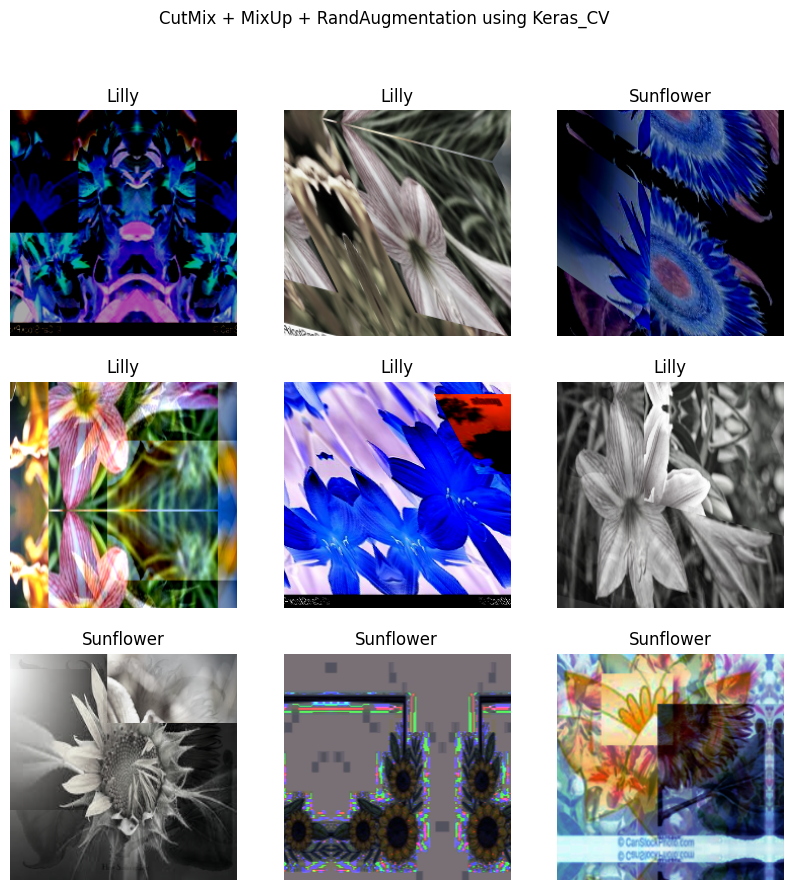

In [11]:
for x, y in train_all_augs:
    outx = x
    outy = y
    break
print(np.min(x), np.max(x))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(dataset.class_names[np.argmax(outy[i].numpy())])
    plt.imshow(outx[i])
    plt.axis("off")
plt.suptitle('CutMix + MixUp + RandAugmentation using Keras_CV')
plt.show()

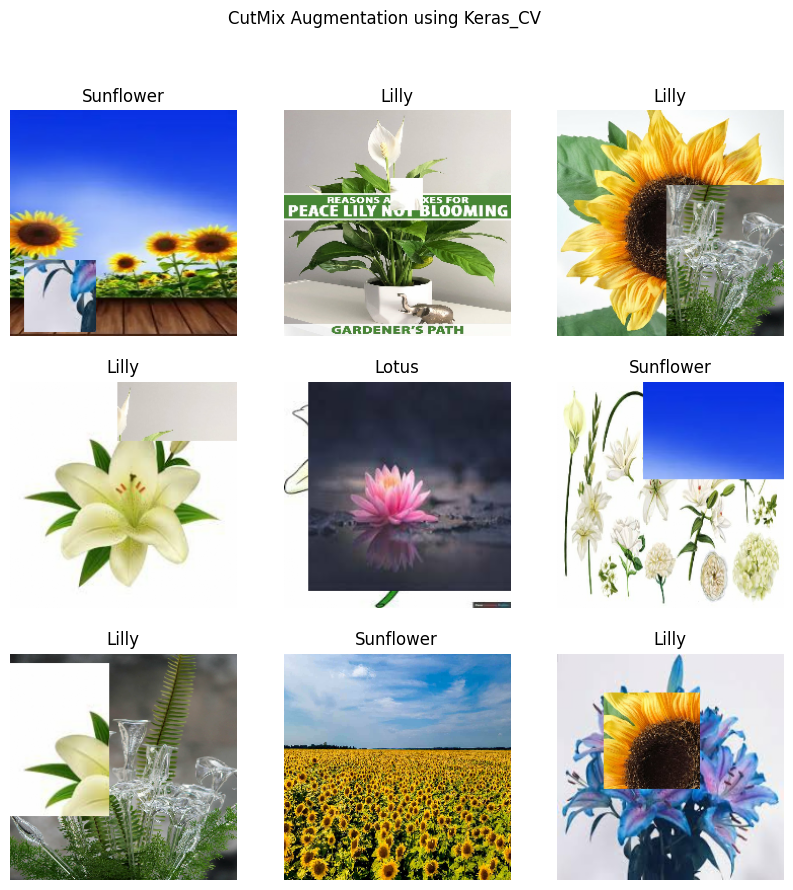

In [12]:
for x in train_cm:
    out = x
    break

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(dataset.class_names[np.argmax(out['labels'][i].numpy())])
    plt.imshow(out['images'][i])
    plt.axis("off")
plt.suptitle('CutMix Augmentation using Keras_CV')
plt.show()

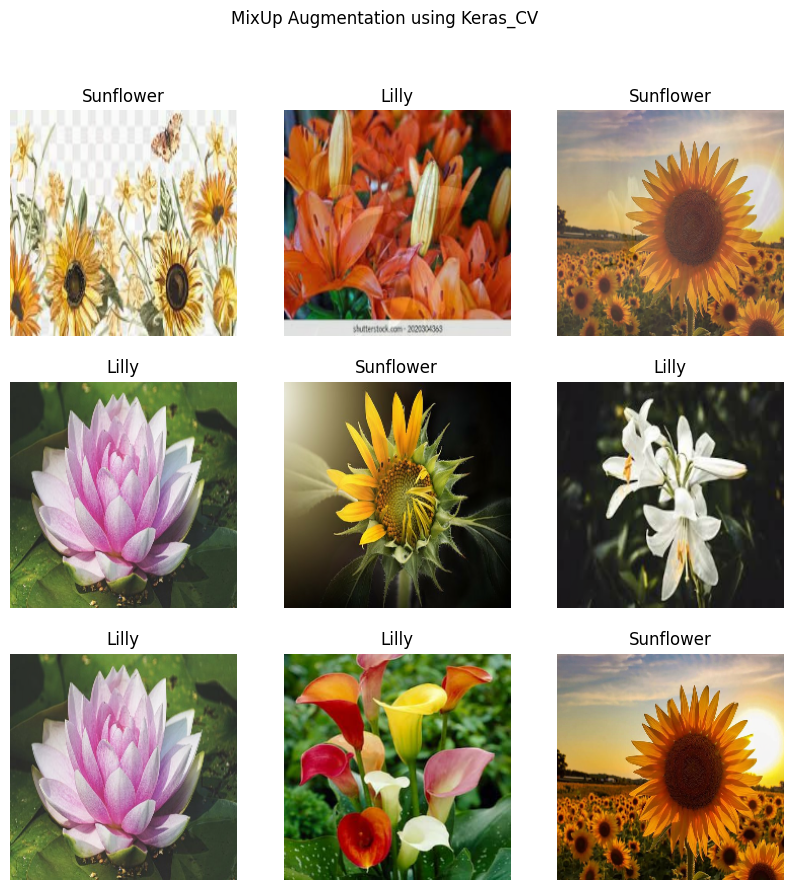

In [13]:
for x in train_mu:
    out = x
    break

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(dataset.class_names[np.argmax(out['labels'][i].numpy())])
    plt.imshow(out['images'][i])
    plt.axis("off")
plt.suptitle('MixUp Augmentation using Keras_CV')
plt.show()

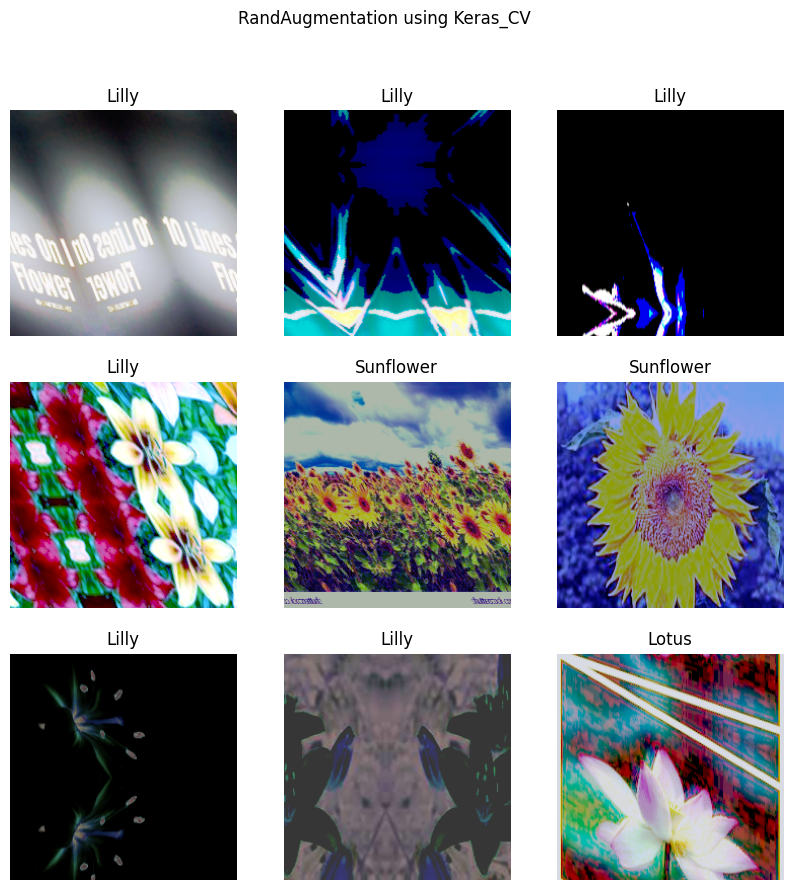

In [14]:
for x in train_ra:
    out = x
    break

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(dataset.class_names[np.argmax(out['labels'][i].numpy())])
    plt.imshow(out['images'][i])
    plt.axis("off")
plt.suptitle('RandAugmentation using Keras_CV')
plt.show()

In [25]:
class Augmentation(keras.layers.Layer):
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)
        self.cutmix = keras_cv.layers.CutMix(alpha=1.0, seed=SEED)
        self.mixup = keras_cv.layers.MixUp(alpha=0.2, seed=SEED)
    
    def call(self, inputs):
        print(inputs.shape)
        out = {'images': inputs, 'labels': y}
        out = cutmix({"images": out['images'], "labels": out['labels']})
        out = mixup({"images": out['images'], "labels": out['labels']})
        out = apply_pipeline({"images": out['images'], "labels": out['labels']})
        # print(out['labels'].shape)
        return (out['images'], out['labels'])

In [26]:
def ConvMixer(dim: int, patch_size: int, depth: int, kernel_size: int, num_classes: int):
    
    input = keras.Input(shape=image_shape + (3,))
    
    
    x = keras.layers.Rescaling(scale=1/255.0)(input)
    x = Augmentation()(x)
    x = keras.layers.Conv2D(filters=dim, kernel_size=patch_size, strides=patch_size)(x)
    x = keras.layers.Activation('gelu')(x)
    x1 = keras.layers.BatchNormalization()(x)
    
    for i in range(depth):
        x = keras.layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x1)
        # x = keras.layers.Conv2D(filters=dim, kernel_size=kernel_size, padding='same', groups=dim, activation='gelu')(x1)
        x = keras.layers.Activation('gelu')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.add([x1, x])
        
        x = keras.layers.Conv2D(filters=dim, kernel_size=1)(x)
        x = keras.layers.Activation('gelu')(x)
        x1 = keras.layers.BatchNormalization()(x)
    
    x = keras.layers.GlobalAvgPool2D()(x1)
    x = keras.layers.Flatten()(x)
    output = keras.layers.Dense(units=num_classes, activation='softmax')(x)
    
    
    return keras.Model(input, output)

In [27]:
model = ConvMixer(dim=512, depth=12, patch_size=7, kernel_size=8, num_classes=5)

(None, 224, 224, 3)


ValueError: Layer "conv2d_13" expects 1 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor 'Placeholder:0' shape=(None, 224, 224, 3) dtype=float32>, <tf.Tensor 'Placeholder_1:0' shape=(10, 5) dtype=float32>]

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 512)  75776       ['rescaling[0][0]']              
                                                                                                  
 activation (Activation)        (None, 32, 32, 512)  0           ['conv2d[0][0]']             

In [18]:
callbacks = [
    keras.callbacks.TensorBoard(), 
    keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
    keras.callbacks.ModelCheckpoint(filepath='checkpoints/convmixer-512-12.h5', save_best_only=True, save_weights_only=True, monitor='val_accuracy'),
    ]

In [24]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics='accuracy',
    )

history = model.fit(train_all_augs, epochs=50, batch_size=BATCH_SIZE, validation_data=val_ds, callbacks=callbacks, verbose='auto')

Epoch 1/50
 18/400 [>.............................] - ETA: 6:48 - loss: 1.5983 - accuracy: 0.4444

KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = sns.lineplot(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']}, ax=axes[0])
ax.set(xlabel='Epoch', ylabel='Loss')
ax = sns.lineplot(data={'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}, ax=axes[1])
ax.set(xlabel='Epoch', ylabel='Accuracy', ylim=(0,1))
plt.suptitle("Loss and Accuracy when using CutMix, Mixup & RandAugment")